In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import math
import numpy as np

# Import libraries for running ANOVA and post-hoc test
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Import Data

* Read files
* Create a mapping table of countries in both tables
* Copy income column to world bank data


In [3]:
# Read the World Bank development indicators dataset

worldbank_path = "../additional_material/week_05_world_bank_development_indicators.csv"
worldbank = pd.read_csv(worldbank_path)

# Read the income dataset (Excel file)
income_path = "../additional_material/week_05_income.xlsx"
income = pd.read_excel(income_path)

# Show the first rows of each dataset to confirm that everything loaded correctly
print("World Bank indicators dataset:")
print(worldbank.head())

print("\nIncome dataset:")
print(income.head())

World Bank indicators dataset:
       country        date  agricultural_land%  forest_land%  land_area  \
0  Afghanistan  1960-01-01                 NaN           NaN        NaN   
1  Afghanistan  1961-01-01           57.878356           NaN   652230.0   
2  Afghanistan  1962-01-01           57.955016           NaN   652230.0   
3  Afghanistan  1963-01-01           58.031676           NaN   652230.0   
4  Afghanistan  1964-01-01           58.116002           NaN   652230.0   

   avg_precipitation  trade_in_services%  control_of_corruption_estimate  \
0                NaN                 NaN                             NaN   
1              327.0                 NaN                             NaN   
2              327.0                 NaN                             NaN   
3              327.0                 NaN                             NaN   
4              327.0                 NaN                             NaN   

   control_of_corruption_std  access_to_electricity%  ...  \


## Are the countries equivalent in both datasets?

In [4]:
# 1. Keep only real countries in the income dataset
#    Idea: real countries have an "income_group", regions usually do NOT
income_countries_df = income[income["Income group"].notna()]

# 2. Get the list of country names from both datasets
income_countries = income_countries_df["Economy"].dropna().unique()
worldbank_countries = worldbank["country"].dropna().unique()

print("Number of countries in income dataset:", len(income_countries))
print("Number of countries in World Bank dataset:", len(worldbank_countries))

# 3. Convert to sets for an easy comparison
income_countries_set = set(income_countries)
worldbank_countries_set = set(worldbank_countries)

# 4. Countries that are in income.xlsx but NOT in the World Bank indicators
only_in_income = income_countries_set - worldbank_countries_set

# 5. Countries that are in the World Bank indicators but NOT in income.xlsx
only_in_worldbank = worldbank_countries_set - income_countries_set

print("\nCountries only in income dataset (not in World Bank):")
print(sorted(only_in_income))

print("\nCountries only in World Bank dataset (not in income dataset):")
print(sorted(only_in_worldbank))


Number of countries in income dataset: 216
Number of countries in World Bank dataset: 274

Countries only in income dataset (not in World Bank):
['Curaçao', 'Côte d’Ivoire', 'Puerto Rico (U.S.)', 'Somalia, Fed. Rep.', 'São Tomé and Príncipe', 'Taiwan, China', 'Türkiye']

Countries only in World Bank dataset (not in income dataset):
['Africa Eastern and Southern', 'Africa Western and Central', 'Arab World', 'Caribbean small states', 'Central Europe and the Baltics', "Cote d'Ivoire", 'Curacao', 'Czech Republic', 'Early-demographic dividend', 'East Asia & Pacific', 'East Asia & Pacific (IDA & IBRD countries)', 'East Asia & Pacific (IDA & IBRD)', 'East Asia & Pacific (excluding high income)', 'Ethiopia', 'Euro area', 'Europe & Central Asia', 'Europe & Central Asia (IDA & IBRD countries)', 'Europe & Central Asia (IDA & IBRD)', 'Europe & Central Asia (excluding high income)', 'European Union', 'Fragile and conflict affected situations', 'Heavily indebted poor countries (HIPC)', 'High income'

They are not. We will now convert the unique names from the income dataset into the equivalent names of the world bank dataset, so that we can merge them afterwards.


In [5]:
# Clean the country names in the income dataset

rename_dict = {
    "Curaçao": "Curacao",
    "Côte d’Ivoire": "Cote d'Ivoire",
    "Puerto Rico (U.S.)": "Puerto Rico",
    "Somalia, Fed. Rep.": "Somalia",
    "São Tomé and Príncipe": "Sao Tome and Principe",
    "Türkiye": "Turkiye"
}

income["Economy"] = income["Economy"].replace(rename_dict)

# Drop Taiwan completely as it does not exist in the other dataset
income = income[income["Economy"] != "Taiwan, China"]

# Filter income dataset to include only countries (not regions)
income_countries_df = income[income["Income group"].notna()]

#  Extract updated unique country lists
income_countries = set(income_countries_df["Economy"].dropna().unique())
worldbank_countries = set(worldbank["country"].dropna().unique())

# Compare again: check for mismatches

only_in_income = income_countries - worldbank_countries
only_in_worldbank = worldbank_countries - income_countries

print("Number of countries in income dataset after cleaning:", len(income_countries))
print("Number of countries in World Bank dataset:", len(worldbank_countries))

print("\nCountries only in income dataset (not in World Bank):")
print(sorted(only_in_income))

print("\nCountries only in World Bank dataset (not in income dataset):")
print(sorted(only_in_worldbank))


Number of countries in income dataset after cleaning: 215
Number of countries in World Bank dataset: 274

Countries only in income dataset (not in World Bank):
[]

Countries only in World Bank dataset (not in income dataset):
['Africa Eastern and Southern', 'Africa Western and Central', 'Arab World', 'Caribbean small states', 'Central Europe and the Baltics', 'Czech Republic', 'Early-demographic dividend', 'East Asia & Pacific', 'East Asia & Pacific (IDA & IBRD countries)', 'East Asia & Pacific (IDA & IBRD)', 'East Asia & Pacific (excluding high income)', 'Ethiopia', 'Euro area', 'Europe & Central Asia', 'Europe & Central Asia (IDA & IBRD countries)', 'Europe & Central Asia (IDA & IBRD)', 'Europe & Central Asia (excluding high income)', 'European Union', 'Fragile and conflict affected situations', 'Heavily indebted poor countries (HIPC)', 'High income', 'IBRD only', 'IDA & IBRD total', 'IDA blend', 'IDA only', 'IDA total', 'Late-demographic dividend', 'Latin America & Caribbean', 'Lati

now we can merge the datasets

In [6]:
# Keep only the columns we need from the income dataset
income_small = income[["Economy", "Region", "Income group"]]

# Merge the two dataframes
#    - match country (worldbank) with Economy (income)
worldbank_merged = pd.merge(
    worldbank,
    income_small,
    how="left",          # keep all rows from worldbank
    left_on="country",
    right_on="Economy"
)

# drop the 'Economy' column because we now use 'country'
worldbank_merged = worldbank_merged.drop(columns=["Economy"])

# Move 'Region' and 'Income group' directly behind 'country'
cols = worldbank_merged.columns.tolist()

# Remove 'Region' and 'Income group' from their current position
cols.remove("Region")
cols.remove("Income group")

# Find the index of 'country'
country_index = cols.index("country")

# Insert 'Region' and 'Income group' after 'country'
cols.insert(country_index + 1, "Region")
cols.insert(country_index + 2, "Income group")

# Reorder the dataframe
worldbank_merged = worldbank_merged[cols]

# Check the result
print(worldbank_merged.head())
print("\nColumns in merged dataframe:")
print(worldbank_merged.columns)


       country                                             Region  \
0  Afghanistan  Middle East, North Africa, Afghanistan & Pakistan   
1  Afghanistan  Middle East, North Africa, Afghanistan & Pakistan   
2  Afghanistan  Middle East, North Africa, Afghanistan & Pakistan   
3  Afghanistan  Middle East, North Africa, Afghanistan & Pakistan   
4  Afghanistan  Middle East, North Africa, Afghanistan & Pakistan   

  Income group        date  agricultural_land%  forest_land%  land_area  \
0   Low income  1960-01-01                 NaN           NaN        NaN   
1   Low income  1961-01-01           57.878356           NaN   652230.0   
2   Low income  1962-01-01           57.955016           NaN   652230.0   
3   Low income  1963-01-01           58.031676           NaN   652230.0   
4   Low income  1964-01-01           58.116002           NaN   652230.0   

   avg_precipitation  trade_in_services%  control_of_corruption_estimate  ...  \
0                NaN                 NaN             

In [7]:
# Rename the two columns to lowercase
worldbank_merged = worldbank_merged.rename(columns={
    "Region": "region",
    "Income group": "income_group"
})

# Check result
print(worldbank_merged.columns)


Index(['country', 'region', 'income_group', 'date', 'agricultural_land%',
       'forest_land%', 'land_area', 'avg_precipitation', 'trade_in_services%',
       'control_of_corruption_estimate', 'control_of_corruption_std',
       'access_to_electricity%', 'renewvable_energy_consumption%',
       'electric_power_consumption', 'CO2_emisions',
       'other_greenhouse_emisions', 'population_density', 'inflation_annual%',
       'real_interest_rate', 'risk_premium_on_lending',
       'research_and_development_expenditure%', 'central_goverment_debt%',
       'tax_revenue%', 'expense%', 'goverment_effectiveness_estimate',
       'goverment_effectiveness_std', 'human_capital_index', 'doing_business',
       'time_to_get_operation_license', 'statistical_performance_indicators',
       'individuals_using_internet%', 'logistic_performance_index',
       'military_expenditure%', 'GDP_current_US',
       'political_stability_estimate', 'political_stability_std',
       'rule_of_law_estimate', 'rul

In [8]:
# Rename the dataframe
df = worldbank_merged



there are a lot of strange names for the countries. I will delete them by only using the original names from the income dataset and deleting everything else


In [9]:
# Extract the list of valid countries from the cleaned income dataset
valid_countries = income[income["Income group"].notna()]["Economy"].unique()

# Filter df so that only rows with valid countries remain
df = df[df["country"].isin(valid_countries)]

# Reset index
df = df.reset_index(drop=True)

# Check result
print("Number of rows after filtering:", len(df))
print("Remaining unique countries:", len(df["country"].unique()))


Number of rows after filtering: 13727
Remaining unique countries: 215


now I will inspect the data types and check if some are wrong


In [10]:
print("Current data types:\n")
print(df.dtypes)


# Identify object columns
# These might be strings OR incorrectly loaded numbers

print("\n\nChecking which 'object' columns might actually be numeric...\n")

object_columns = df.select_dtypes(include="object").columns

print("Object columns found:")
print(list(object_columns))



# STEP 3: Try converting object columns into numeric
# If conversion works → column becomes numeric
# If not → column stays object

print("\n\nAttempting safe conversion of object columns...\n")

converted_columns = []
left_as_object = []

for col in object_columns:
    try:
        # Try numeric conversion
        df[col] = pd.to_numeric(df[col], errors="raise")
        converted_columns.append(col)
    except:
        # Leave untouched
        left_as_object.append(col)



# results

print("\n\n=== Conversion Report ===")
print("\nConverted to numeric:")
print(converted_columns)

print("\nLeft as object (kept safe as text):")
print(left_as_object)

# show final datatypes

print("\n\nFinal data types:\n")
print(df.dtypes)


Current data types:

country                                       object
region                                        object
income_group                                  object
date                                          object
agricultural_land%                           float64
forest_land%                                 float64
land_area                                    float64
avg_precipitation                            float64
trade_in_services%                           float64
control_of_corruption_estimate               float64
control_of_corruption_std                    float64
access_to_electricity%                       float64
renewvable_energy_consumption%               float64
electric_power_consumption                   float64
CO2_emisions                                 float64
other_greenhouse_emisions                    float64
population_density                           float64
inflation_annual%                            float64
real_interest_rate       

the output shows that all data types are correct. good, now we can start with the fun part...


## Basic Inspection + Early Visualizations

In [11]:
## Basic Inspection + Early Visualizations

import sys
import subprocess

subprocess.check_call([sys.executable, "-m", "pip", "install", "plotly"])


0

In [12]:
import plotly.express as px

# Create a dataframe with one row per country and its income group
map_df = df[["country", "income_group"]].drop_duplicates(subset="country")

# Create the world map
fig = px.choropleth(
    map_df,
    locations="country",              # column with country names
    locationmode="country names",     # tells plotly that 'country' is a country name
    color="income_group",             # color by income group
    title="World Map of Countries by Income Group",
    labels={"income_group": "Income Group"}
)

# Make the layout nicer
fig.update_layout(
    legend_title_text="Income Group",
    margin=dict(l=0, r=0, t=50, b=0)
)

# Show the figure
fig.show()

In [13]:
# Show the first 5 rows of the dataset
print("First 5 rows of the dataset:")
print(df.head())

# Show the last 5 rows of the dataset
print("\nLast 5 rows of the dataset:")
print(df.tail())

# Show a random sample of 7 rows
print("\nRandom sample of 7 rows:")
print(df.sample(7, random_state=42))  # random_state makes the result reproducible


First 5 rows of the dataset:
       country                                             region  \
0  Afghanistan  Middle East, North Africa, Afghanistan & Pakistan   
1  Afghanistan  Middle East, North Africa, Afghanistan & Pakistan   
2  Afghanistan  Middle East, North Africa, Afghanistan & Pakistan   
3  Afghanistan  Middle East, North Africa, Afghanistan & Pakistan   
4  Afghanistan  Middle East, North Africa, Afghanistan & Pakistan   

  income_group        date  agricultural_land%  forest_land%  land_area  \
0   Low income  1960-01-01                 NaN           NaN        NaN   
1   Low income  1961-01-01           57.878356           NaN   652230.0   
2   Low income  1962-01-01           57.955016           NaN   652230.0   
3   Low income  1963-01-01           58.031676           NaN   652230.0   
4   Low income  1964-01-01           58.116002           NaN   652230.0   

   avg_precipitation  trade_in_services%  control_of_corruption_estimate  ...  \
0                NaN    

In [14]:
# Check the data types of all columns
print("Data types of each column:")
print(df.dtypes)

Data types of each column:
country                                       object
region                                        object
income_group                                  object
date                                          object
agricultural_land%                           float64
forest_land%                                 float64
land_area                                    float64
avg_precipitation                            float64
trade_in_services%                           float64
control_of_corruption_estimate               float64
control_of_corruption_std                    float64
access_to_electricity%                       float64
renewvable_energy_consumption%               float64
electric_power_consumption                   float64
CO2_emisions                                 float64
other_greenhouse_emisions                    float64
population_density                           float64
inflation_annual%                            float64
real_interest_rate 

In [15]:

# Count how many duplicated rows exist in the dataset
num_duplicates = df.duplicated().sum()

print("Number of duplicated rows:", num_duplicates)

# Optional: show the first few duplicated rows (only if any exist)
if num_duplicates > 0:
    print("\nExample duplicated rows:")
    print(df[df.duplicated()].head())

Number of duplicated rows: 0


In [16]:
# Count missing values per column
missing_counts = df.isna().sum()

# Percentage of missing values
missing_percent = (df.isna().mean() * 100).round(2)

# Combine into one table
missing_table = pd.DataFrame({
    "missing_count": missing_counts,
    "missing_percent": missing_percent
})

print("\nMissing values per column:")
print(missing_table)


Missing values per column:
                                           missing_count  missing_percent
country                                                0             0.00
region                                                 0             0.00
income_group                                           0             0.00
date                                                   0             0.00
agricultural_land%                                  2124            15.47
forest_land%                                        7163            52.18
land_area                                           1908            13.90
avg_precipitation                                   3789            27.60
trade_in_services%                                  6768            49.30
control_of_corruption_estimate                      9016            65.68
control_of_corruption_std                           9016            65.68
access_to_electricity%                              7702            56.11
renewvable

In [17]:
# Select only numerical columns (int and float)
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns

print("Summary statistics for numerical columns:")
print(df[numeric_cols].describe())

Summary statistics for numerical columns:
       agricultural_land%  forest_land%     land_area  avg_precipitation  \
count        11603.000000   6564.000000  1.181900e+04        9938.000000   
mean            36.918102     32.534672  5.997133e+05        1206.377138   
std             22.538148     24.985620  1.648200e+06         812.400412   
min              0.262821      0.000000  2.027000e+00          18.100000   
25%             17.133761     10.896664  1.001000e+04         589.000000   
50%             37.949692     30.564435  9.680000e+04        1083.000000   
75%             54.930736     51.845053  4.528600e+05        1738.000000   
max             93.440750     98.574551  1.638995e+07        3240.000000   

       trade_in_services%  control_of_corruption_estimate  \
count         6959.000000                     4711.000000   
mean            24.025264                       -0.013057   
std             25.640148                        1.002079   
min              0.621025    

In [18]:

# Select only categorical columns (object type)
categorical_cols = df.select_dtypes(include="object").columns

print("\nSummary statistics for categorical columns:")
print(df[categorical_cols].describe())


Summary statistics for categorical columns:
            country                 region income_group        date
count         13727                  13727        13727       13727
unique          215                      7            4          64
top     Afghanistan  Europe & Central Asia  High income  1990-01-01
freq             64                   3712         5504         215


# Research Question analysis: Human well-being and health (e.g., life expectancy, education expenditure, access to electricity, population density)

From here on we look a different indicators that could be related to human well-being and health. We will first visualize some of them and then run an ANOVA test to see if there are significant differences between income groups.


## Governance & Institutional Quality

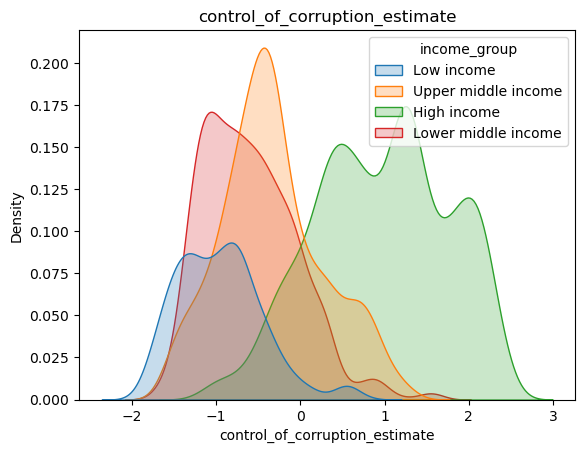

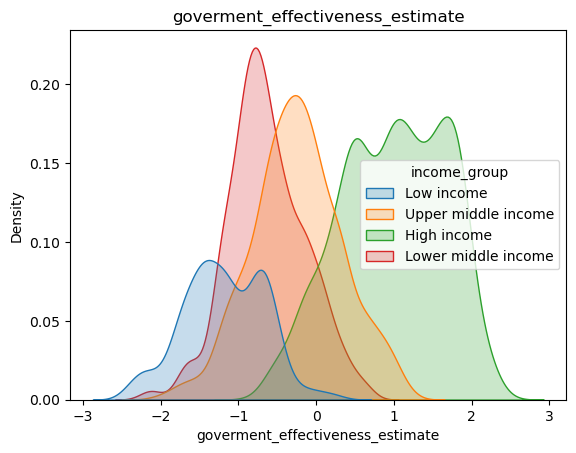

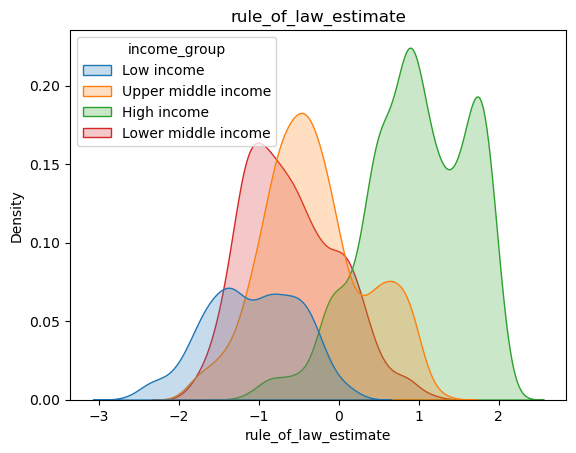

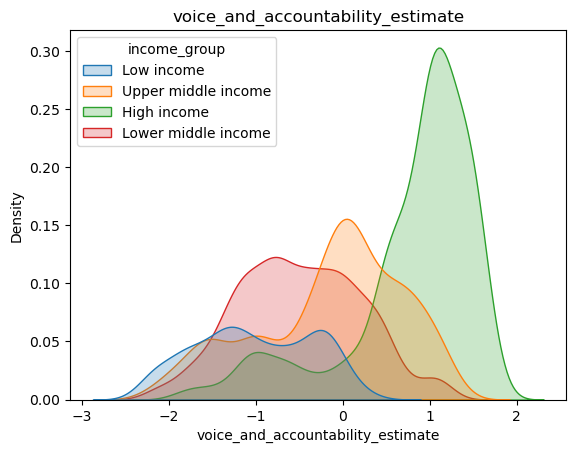

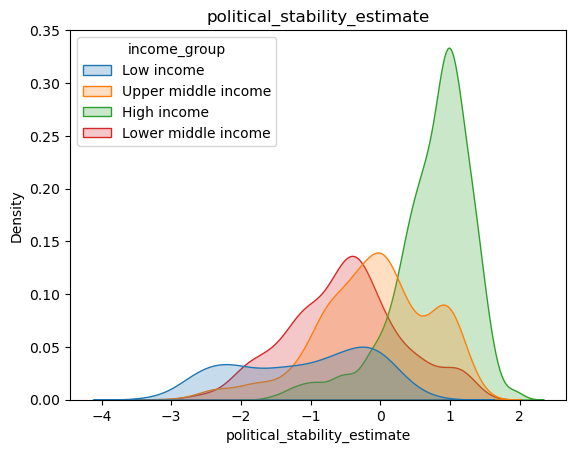

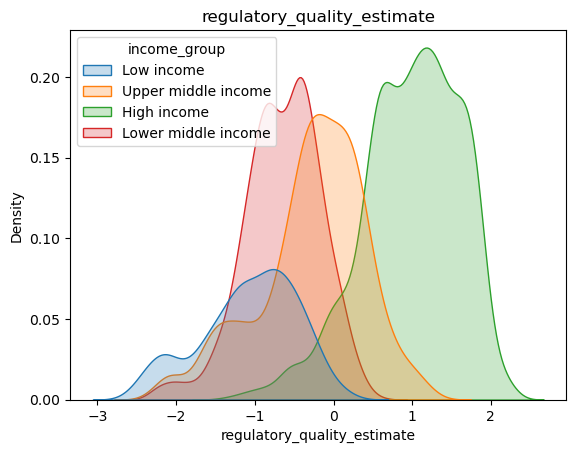

In [19]:
# define relevant columns for governance

gov_cols = [
    "control_of_corruption_estimate",
    "goverment_effectiveness_estimate",
    "rule_of_law_estimate",
    "voice_and_accountability_estimate",
    "political_stability_estimate",
    "regulatory_quality_estimate"
]


for col in gov_cols:
    sns.kdeplot(data=df, x=col, hue="income_group", fill=True)
    plt.title(col)
    plt.show()

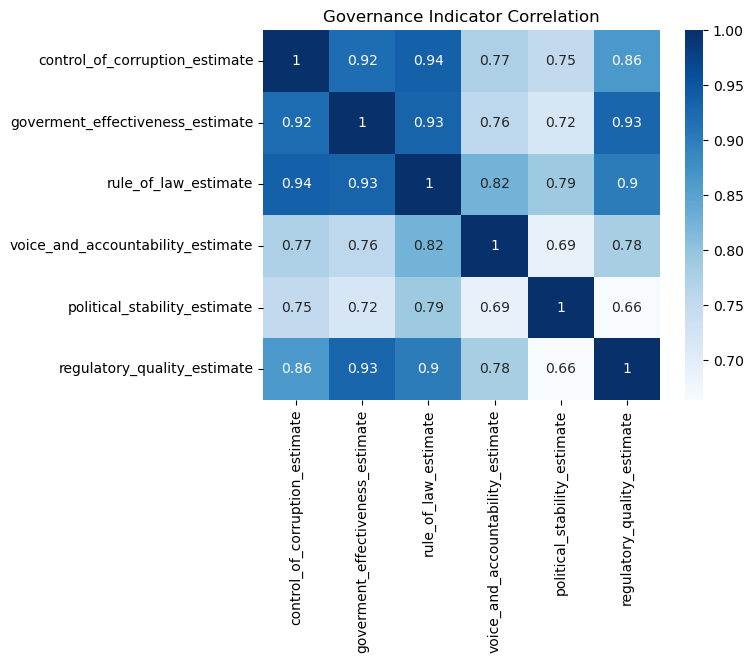

In [20]:
corr = df[gov_cols].corr()

sns.heatmap(corr, annot=True, cmap="Blues")
plt.title("Governance Indicator Correlation")
plt.show()

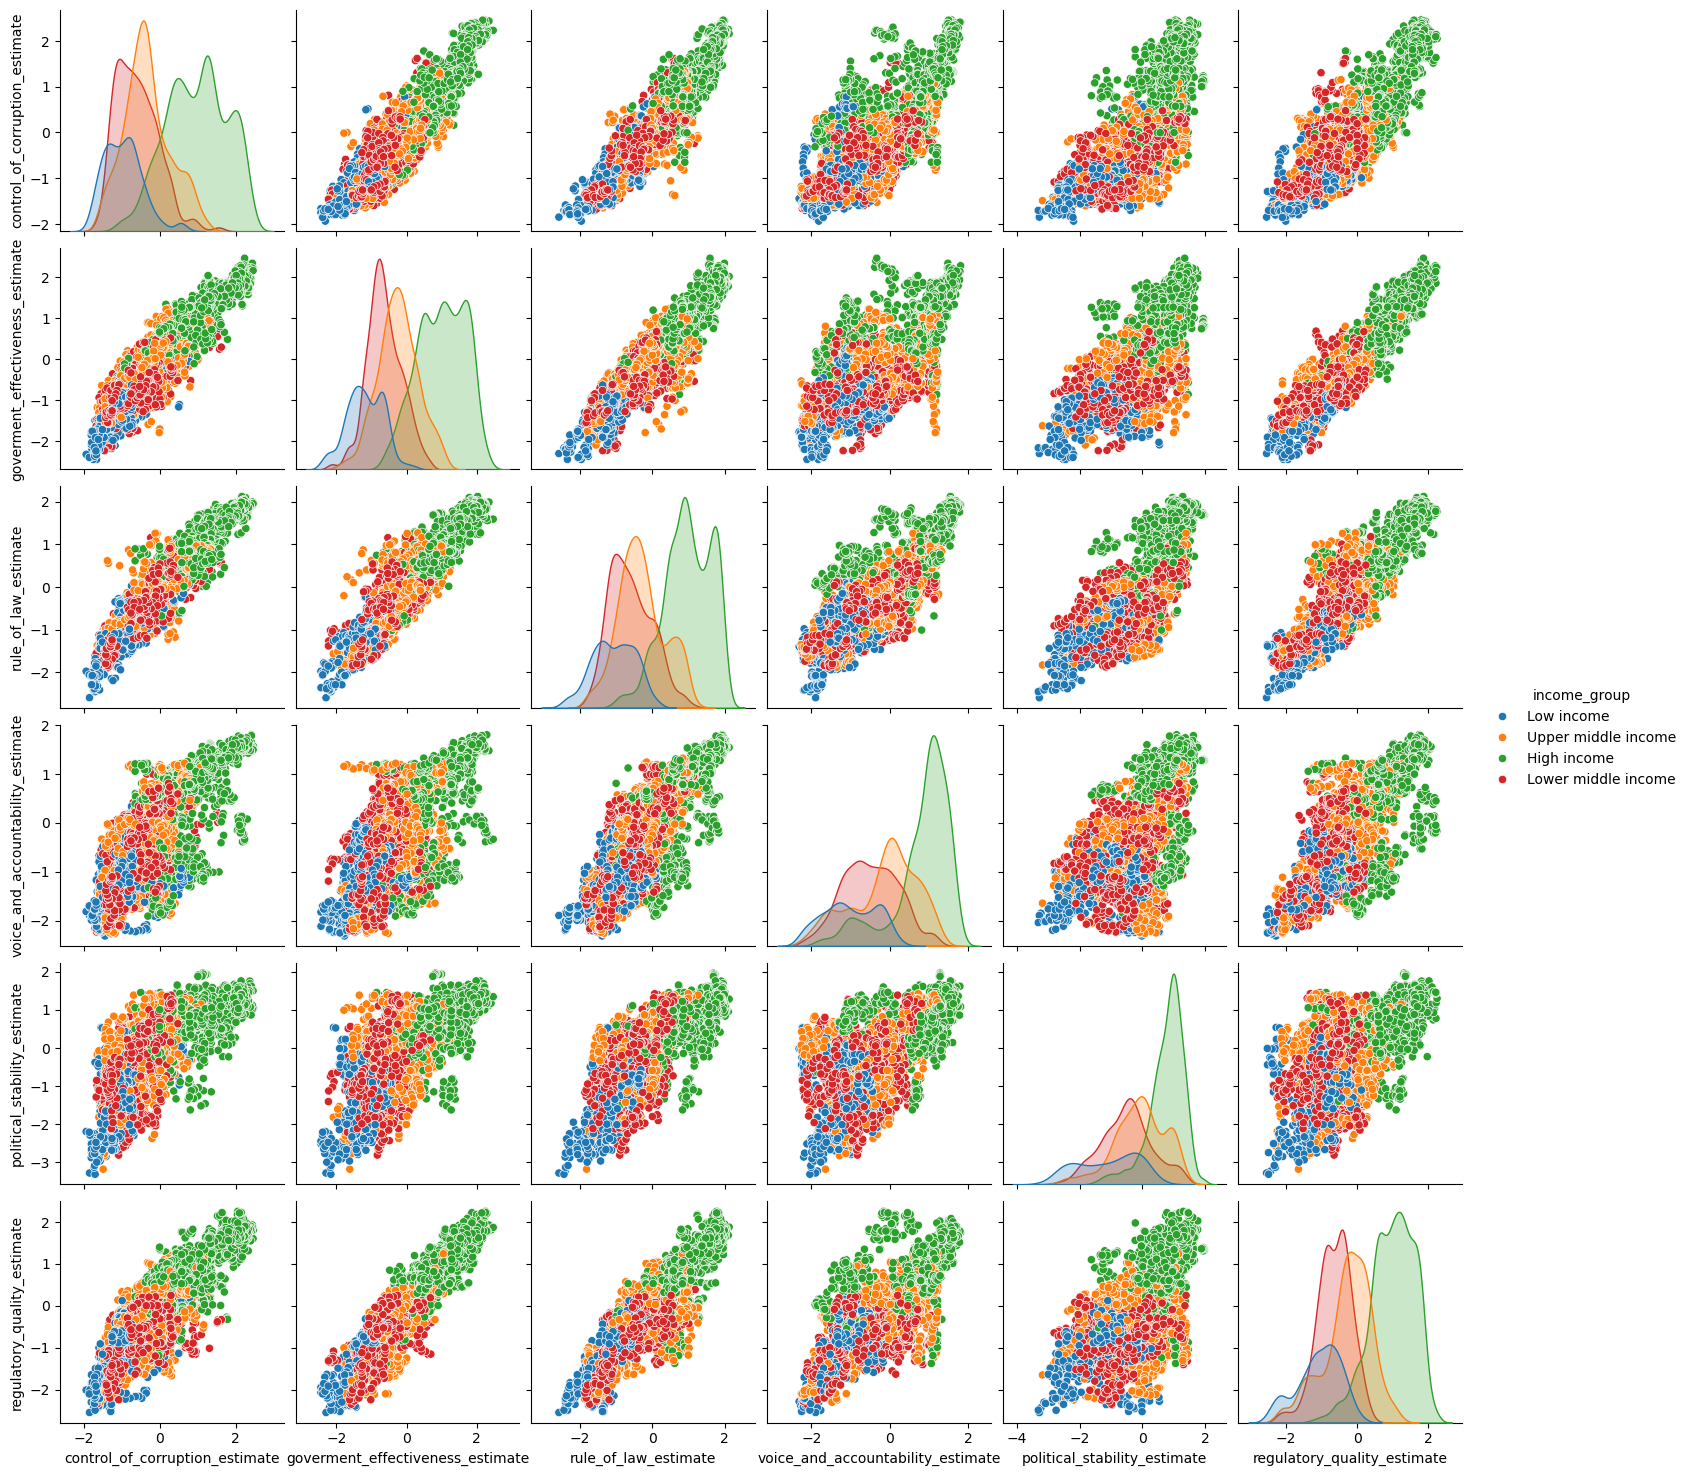

In [21]:
sns.pairplot(df[gov_cols + ["income_group"]], hue="income_group")
plt.show()

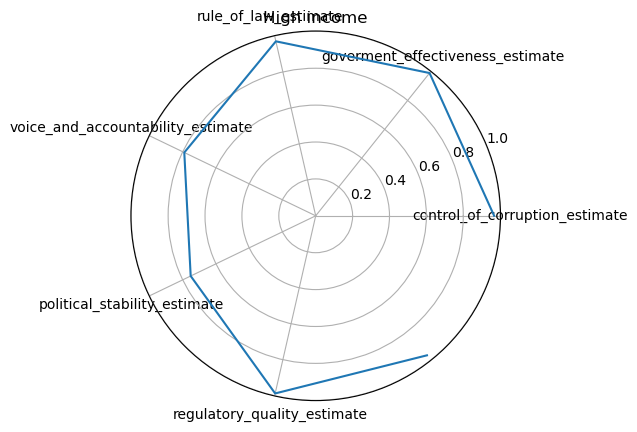

In [22]:

group = "High income"

vals = df[df["income_group"] == group][gov_cols].mean().values
vals = np.append(vals, vals[0])

angles = np.linspace(0, 2 * np.pi, len(vals), endpoint=False)

plt.polar(angles, vals)
plt.xticks(angles[:-1], gov_cols)
plt.title(group)
plt.show()

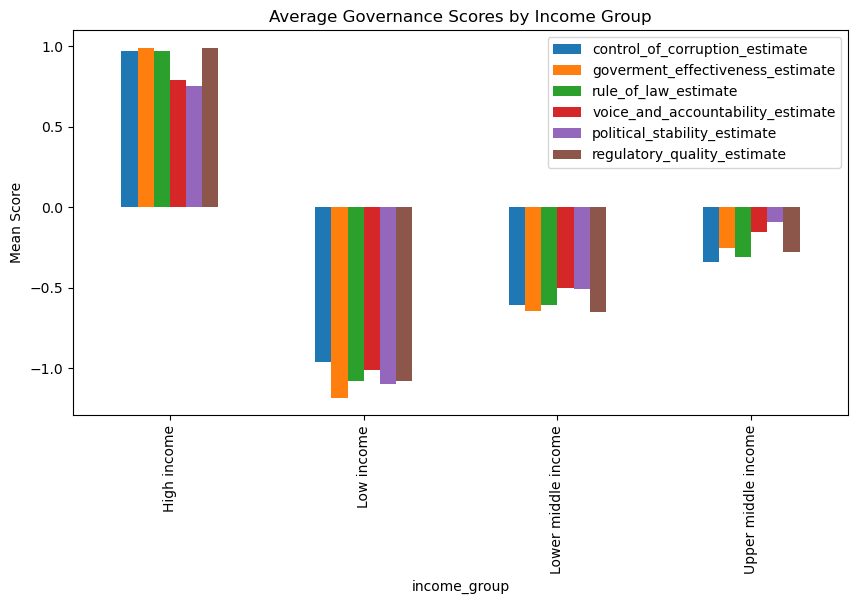

In [23]:
means = df.groupby("income_group")[gov_cols].mean()
means.plot(kind="bar", figsize=(10,5))
plt.title("Average Governance Scores by Income Group")
plt.ylabel("Mean Score")
plt.show()

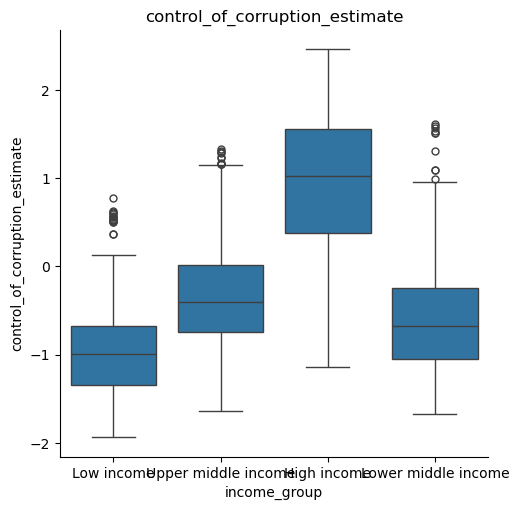

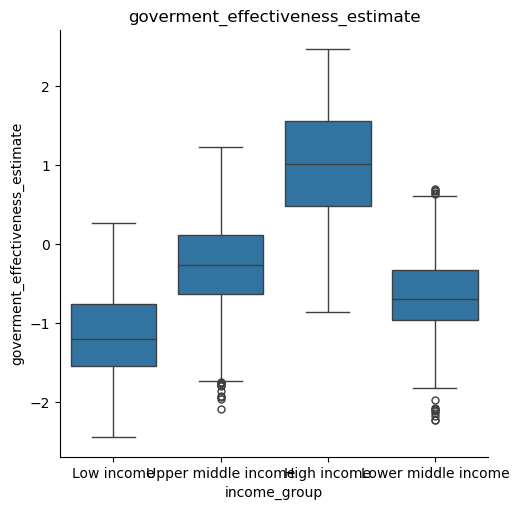

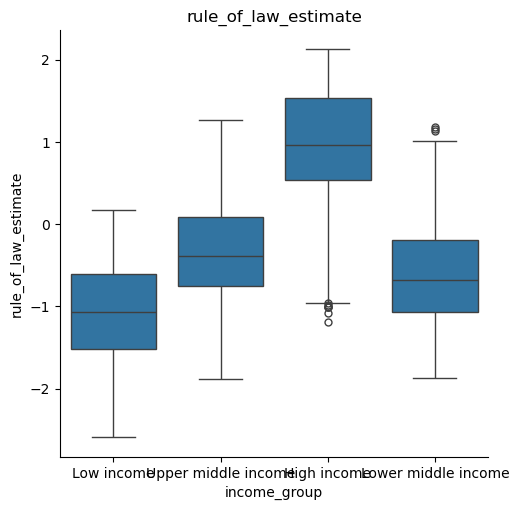

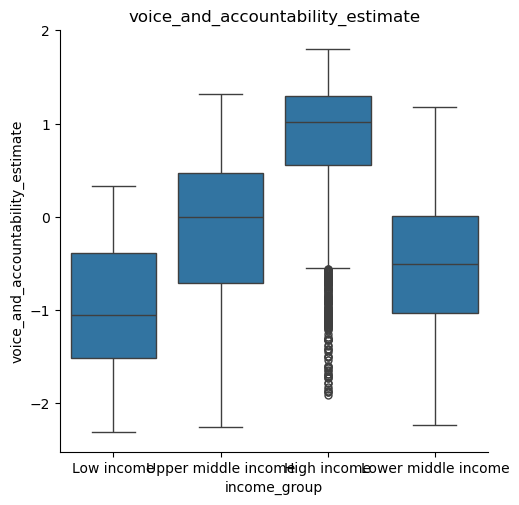

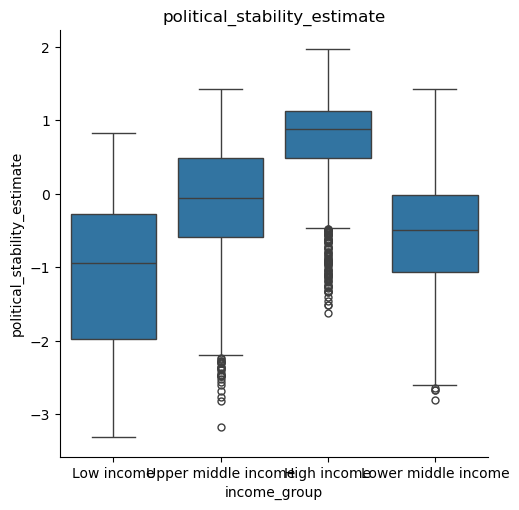

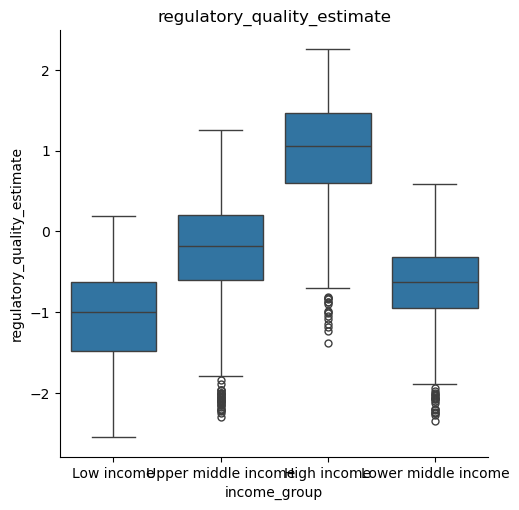

In [24]:

for col in gov_cols:
    sns.catplot(data=df, x="income_group", y=col, kind="box")
    plt.title(col)

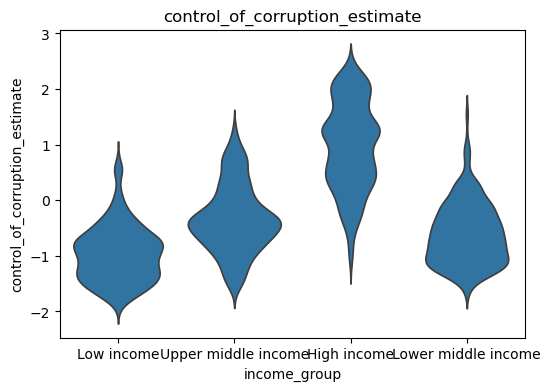

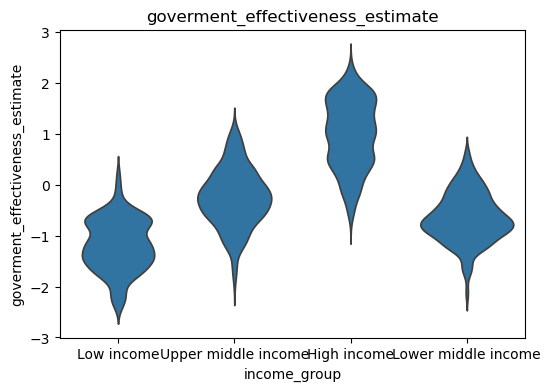

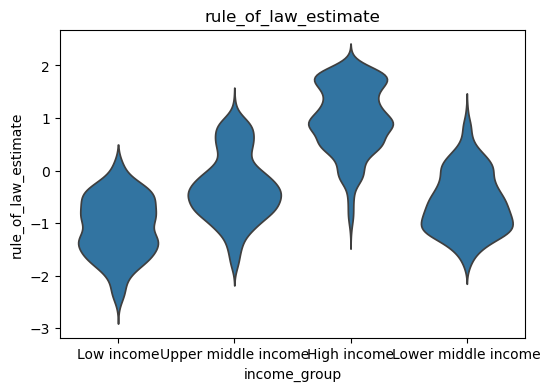

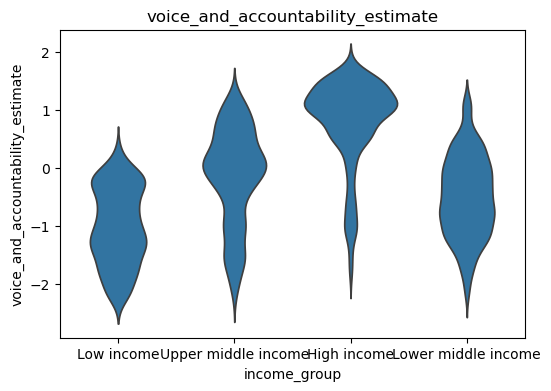

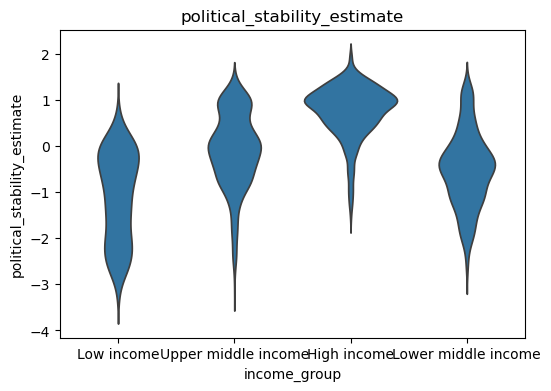

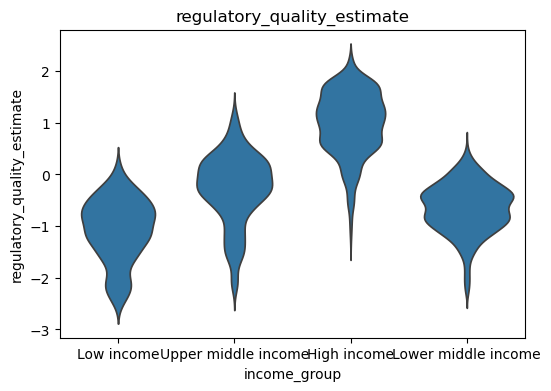

In [25]:
for col in gov_cols:
    plt.figure(figsize=(6,4))
    sns.violinplot(data=df, x="income_group", y=col, inner=None)
    # striplot removed right now; can be reenabled when needed
    #sns.stripplot(data=df, x="income_group", y=col, color="black", size=2, alpha=0.7)
    plt.title(col)
    plt.show()

## Environmental Sustainability

In [26]:
# Create CO2 per capita column only where both CO2 and population exist
df['co2_pc'] = df['CO2_emisions'] / df['population']

Log-transformation applied.

Counts per Income Group:
income_group
High income            5504
Upper middle income    3456
Lower middle income    3167
Low income             1600
Name: count, dtype: int64 



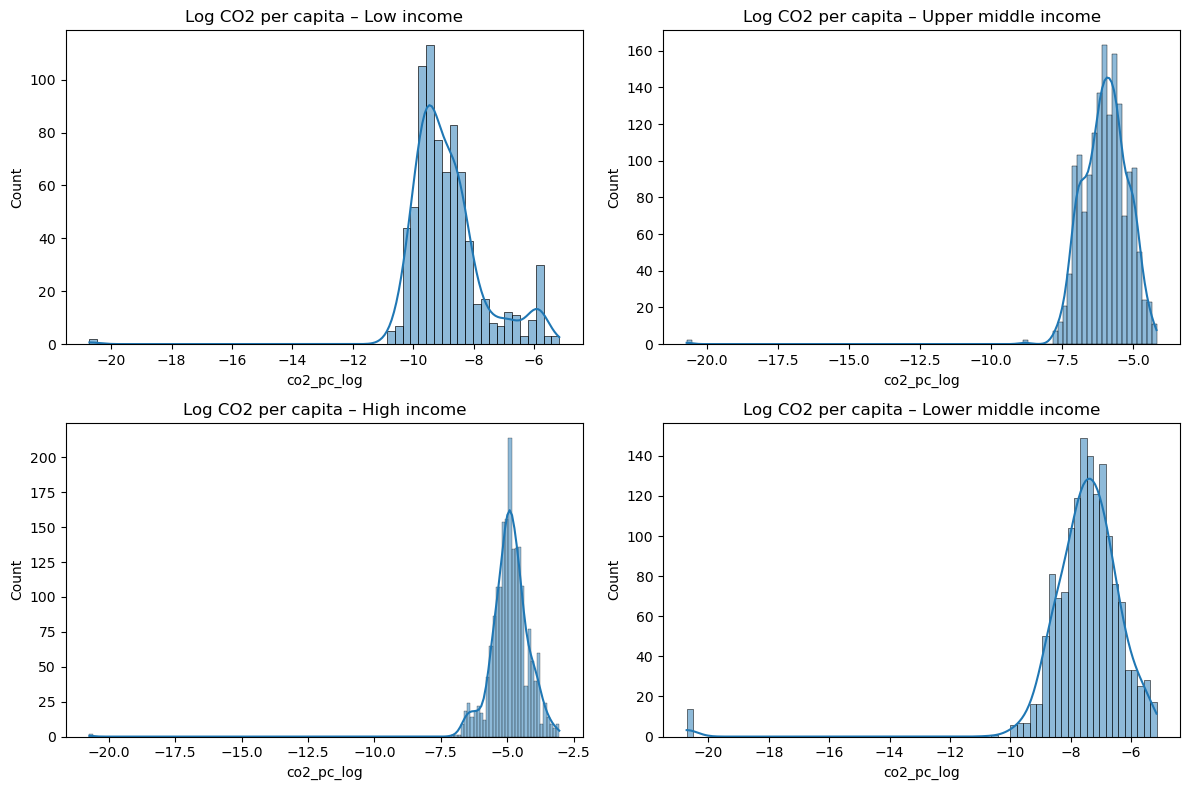

Shapiro-Wilk Normality Test (log-transformed values):

Low income                 stat=0.8052,  p-value=0.00000
Upper middle income        stat=0.7725,  p-value=0.00000
High income                stat=0.7147,  p-value=0.00000
Lower middle income        stat=0.5887,  p-value=0.00000
ANOVA Result (log-transformed CO2 per capita):

                       sum_sq      df            F  PR(>F)
C(income_group)  11262.930368     3.0  2893.397555     0.0
Residual          7555.597677  5823.0          NaN     NaN 

Tukey HSD Post-hoc Test:

             Multiple Comparison of Means - Tukey HSD, FWER=0.05             
       group1              group2       meandiff p-adj  lower   upper  reject
-----------------------------------------------------------------------------
        High income          Low income   -3.973   0.0 -4.0976 -3.8485   True
        High income Lower middle income  -2.6307   0.0 -2.7318 -2.5296   True
        High income Upper middle income  -1.0744   0.0 -1.1727  -0.976   T

In [27]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# ---------------------------------------------------------
# 1. Log-transform CO2-per-capita (safe log)
# ---------------------------------------------------------
df['co2_pc_log'] = np.log(df['co2_pc'] + 1e-9)

print("Log-transformation applied.\n")

# ---------------------------------------------------------
# 2. Counts per Income Group
# ---------------------------------------------------------
print("Counts per Income Group:")
print(df['income_group'].value_counts(dropna=False), "\n")

# ---------------------------------------------------------
# 3. Histogram inspection (log-transformed)
#    — fix subplot bug by breaking after 4 plots
# ---------------------------------------------------------
plt.figure(figsize=(12, 8))

for i, group in enumerate(df['income_group'].unique()):
    if i >= 4:  # you only have 4 subplot positions
        break

    subset = df[df['income_group'] == group]['co2_pc_log'].dropna()
    plt.subplot(2, 2, i + 1)
    sns.histplot(subset, kde=True)
    plt.title(f"Log CO2 per capita – {group}")

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 4. Shapiro-Wilk normality test (log-transformed)
# ---------------------------------------------------------
print("Shapiro-Wilk Normality Test (log-transformed values):\n")

# nur echte Einkommensgruppen (ohne NaN)
valid_groups = [g for g in df['income_group'].unique() if pd.notna(g)]

for group in valid_groups:
    subset = df[df['income_group'] == group]['co2_pc_log'].dropna()

    # Shapiro braucht mindestens n=3, sonst gibt es Warnungen / NaN
    if len(subset) < 3:
        print(f"{str(group):25}  too few observations for Shapiro-Wilk (n={len(subset)})")
        continue

    stat, p = stats.shapiro(subset)
    print(f"{str(group):25}  stat={stat:.4f},  p-value={p:.5f}")

# ---------------------------------------------------------
# 6. ANOVA (log-transformed)
# ---------------------------------------------------------
df_anova = df.rename(columns={'income_group': 'income_group'})

model = ols('co2_pc_log ~ C(income_group)', data=df_anova).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("ANOVA Result (log-transformed CO2 per capita):\n")
print(anova_table, "\n")

# ---------------------------------------------------------
# 7. Tukey HSD post-hoc test (nur vollständige, saubere Zeilen)
# ---------------------------------------------------------
tukey_df = df_anova[['co2_pc_log', 'income_group']].dropna().copy()

# sicherstellen, dass die Gruppen nur Strings sind
tukey_df['income_group'] = tukey_df['income_group'].astype(str)

tukey = pairwise_tukeyhsd(
    endog=tukey_df['co2_pc_log'],
    groups=tukey_df['income_group'],
    alpha=0.05
)

print("Tukey HSD Post-hoc Test:\n")
print(tukey)


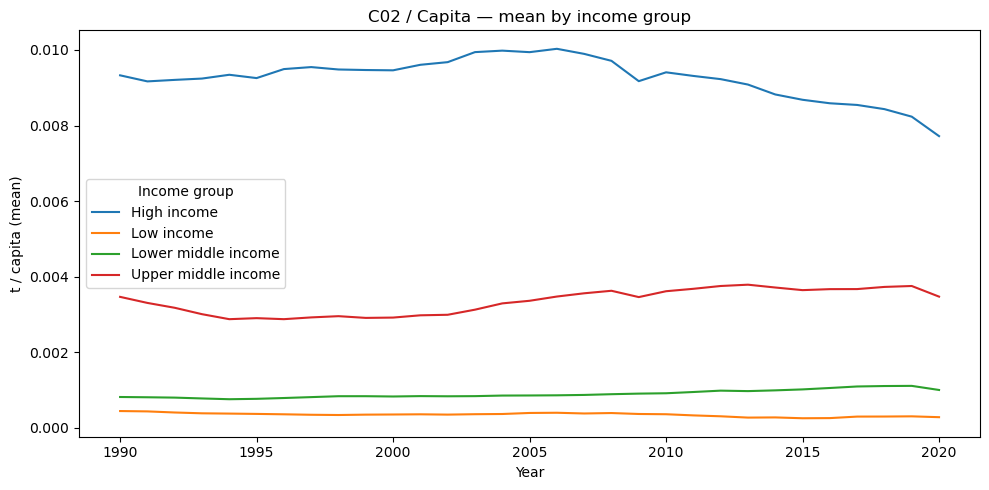

In [28]:
# Build Year from 'date'
df['Year'] = pd.to_datetime(df['date'], errors='coerce').dt.year

value_col = 'co2_pc'
income_col = 'income_group'

work = df[
    df[value_col].notna()
    & df['Year'].notna()
    & df[income_col].notna()
]

pivot = (work.groupby(['Year', income_col])[value_col]
             .mean()
             .unstack(income_col)
             .sort_index())

plt.figure(figsize=(10, 5))
for col in pivot.columns:
    plt.plot(pivot.index, pivot[col], label=str(col))
plt.title("C02 / Capita — mean by income group")
plt.xlabel("Year")
plt.ylabel("t / capita (mean)")
plt.legend(title="Income group")
plt.tight_layout()
plt.show()


# Analysis of energy consumption between income groups

Analysis followed by statistical testing (ANOVA + Tukey HSD)

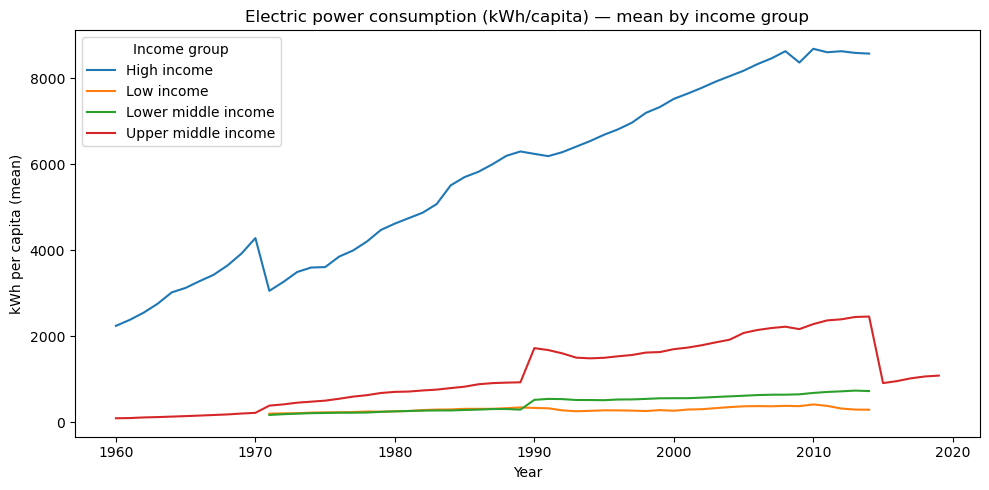

In [29]:
# Build Year from 'date'
df['Year'] = pd.to_datetime(df['date'], errors='coerce').dt.year

value_col = 'electric_power_consumption'
income_col = 'income_group'

work = df[
    df[value_col].notna()
    & df['Year'].notna()
    & df[income_col].notna()
]

pivot = (work.groupby(['Year', income_col])[value_col]
             .mean()
             .unstack(income_col)
             .sort_index())

plt.figure(figsize=(10, 5))
for col in pivot.columns:
    plt.plot(pivot.index, pivot[col], label=str(col))
plt.title("Electric power consumption (kWh/capita) — mean by income group")
plt.xlabel("Year")
plt.ylabel("kWh per capita (mean)")
plt.legend(title="Income group")
plt.tight_layout()
plt.show()


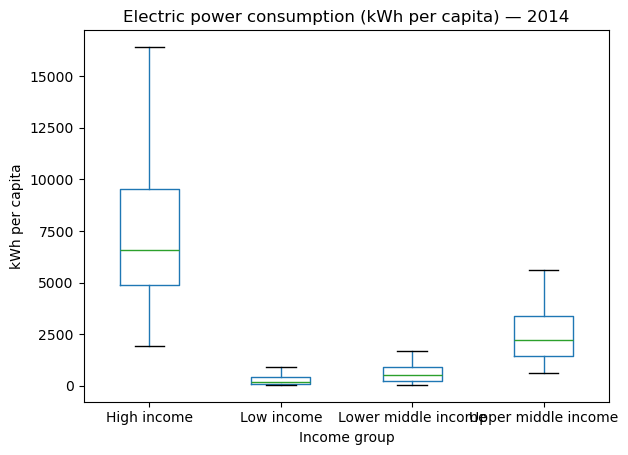

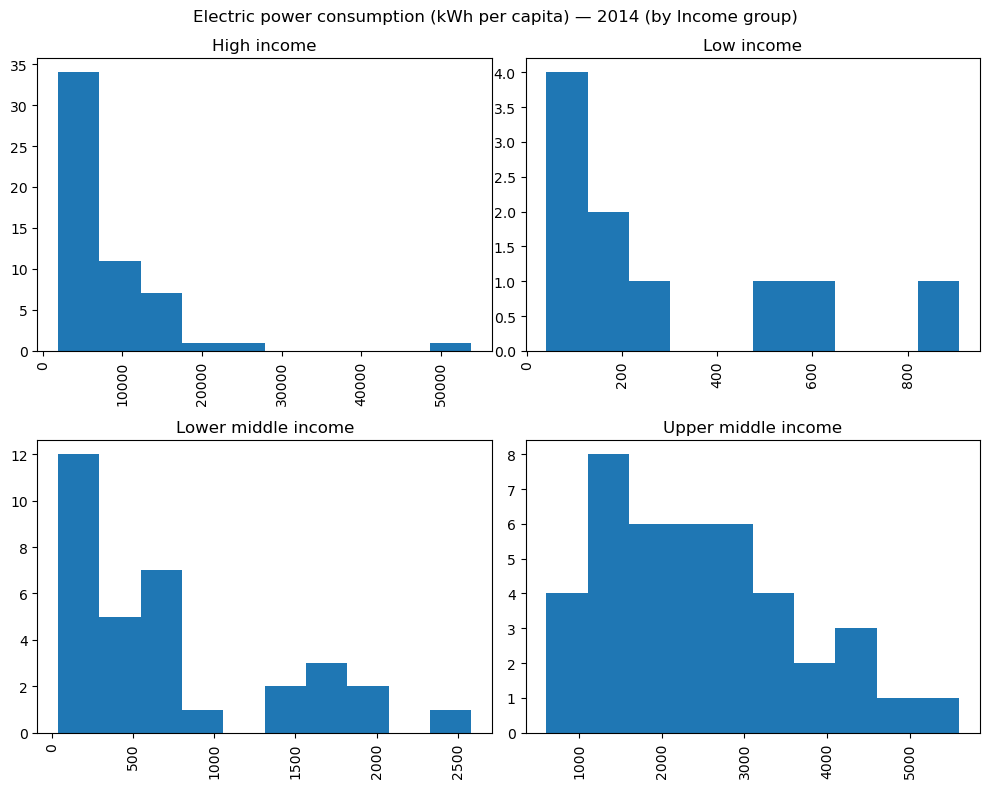

In [30]:
# Filter to 2014 and keep needed columns
df_2014 = df.loc[
    pd.to_datetime(df['date']).dt.year == 2014,
    ['income_group', 'electric_power_consumption']
].dropna()


# Single call: boxplot by income group, outliers hidden
ax = df_2014.boxplot(
    column='electric_power_consumption',
    by='income_group',
    showfliers=False,
    grid=False
)

plt.title('Electric power consumption (kWh per capita) — 2014')
plt.suptitle('')  # removes pandas default super title
plt.xlabel('Income group')
plt.ylabel('kWh per capita')
plt.tight_layout()
plt.show()

axes = df_2014.hist(
    column='electric_power_consumption',
    by='income_group',
    bins=10,
    figsize=(10, 8),
    sharex=False,
    sharey=False,
    grid=False,
)

plt.suptitle('Electric power consumption (kWh per capita) — 2014 (by Income group)')
plt.tight_layout()
plt.show()

The data shows that higher income groups tend to have higher electric power consumption per capita. The boxplot indicates that the High income group has the highest median consumption, followed by Upper-Middle, Lower-Middle, and Low income groups. The histograms reveal that the distribution of consumption values varies across income groups, with the High income group showing a wider range of consumption levels.

Nevertheless, distribution is not normally distributed so I will try to run a log transformation to make it normally distributed

In [31]:
df_2014['electric_power_consumption'] = np.where(
    df_2014['electric_power_consumption'] > 0,
    np.log10(df_2014['electric_power_consumption']),
    np.nan
)

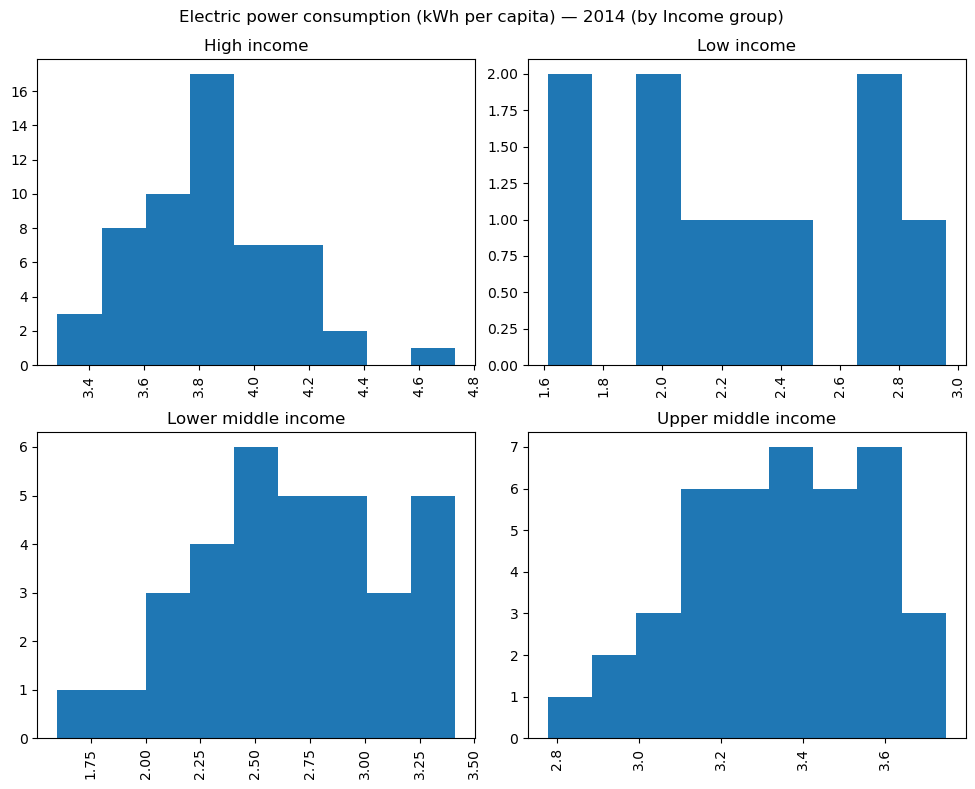

In [32]:
axes = df_2014.hist(
    column='electric_power_consumption',
    by='income_group',
    bins=9,
    figsize=(10, 8),
    sharex=False,
    sharey=False,
    grid=False,
)

plt.suptitle('Electric power consumption (kWh per capita) — 2014 (by Income group)')
plt.tight_layout()
plt.show()

Even with log tranform the data is still not normally distributed. Running an Anova is not feasible.

## Economic Performance and Poverty reduction

C:\Users\Daniel3\AppData\Local\Temp\ipykernel_15916\2807472903.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




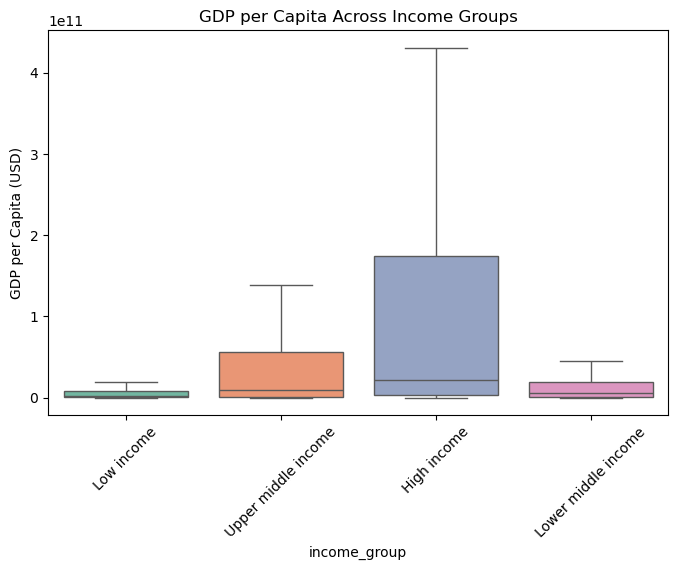

In [33]:
plt.figure(figsize=(8,5))
sns.boxplot(
    x='income_group',
    y='GDP_current_US',
    data=df,
    palette='Set2',
    showfliers=False     # ← hides outliers
)
plt.title('GDP per Capita Across Income Groups')
plt.xlabel('income_group')
plt.ylabel('GDP per Capita (USD)')
plt.xticks(rotation=45)
plt.show()


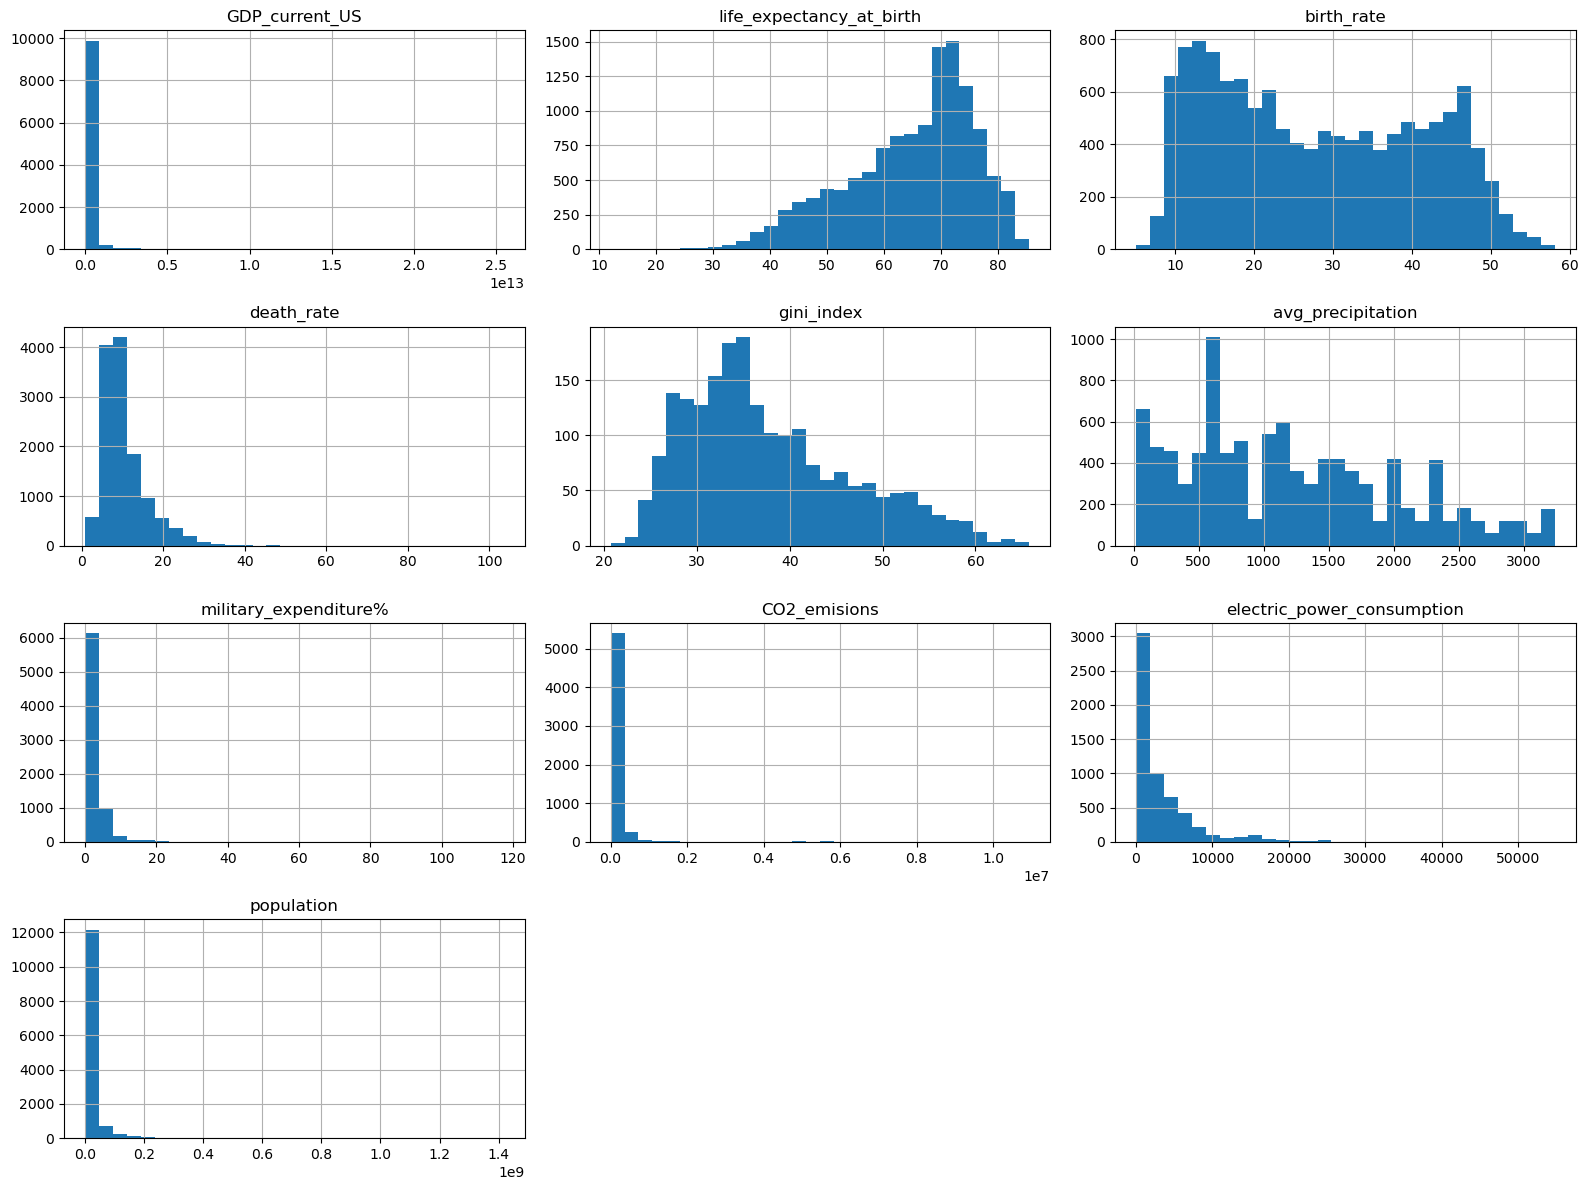

In [34]:
num_cols = [
    'GDP_current_US', 'life_expectancy_at_birth', 'birth_rate', 'death_rate',
    'gini_index', 'avg_precipitation', 'military_expenditure%',
    'CO2_emisions', 'electric_power_consumption', 'population'
]

df[num_cols].hist(figsize=(16, 12), bins=30)
plt.tight_layout()
plt.show()

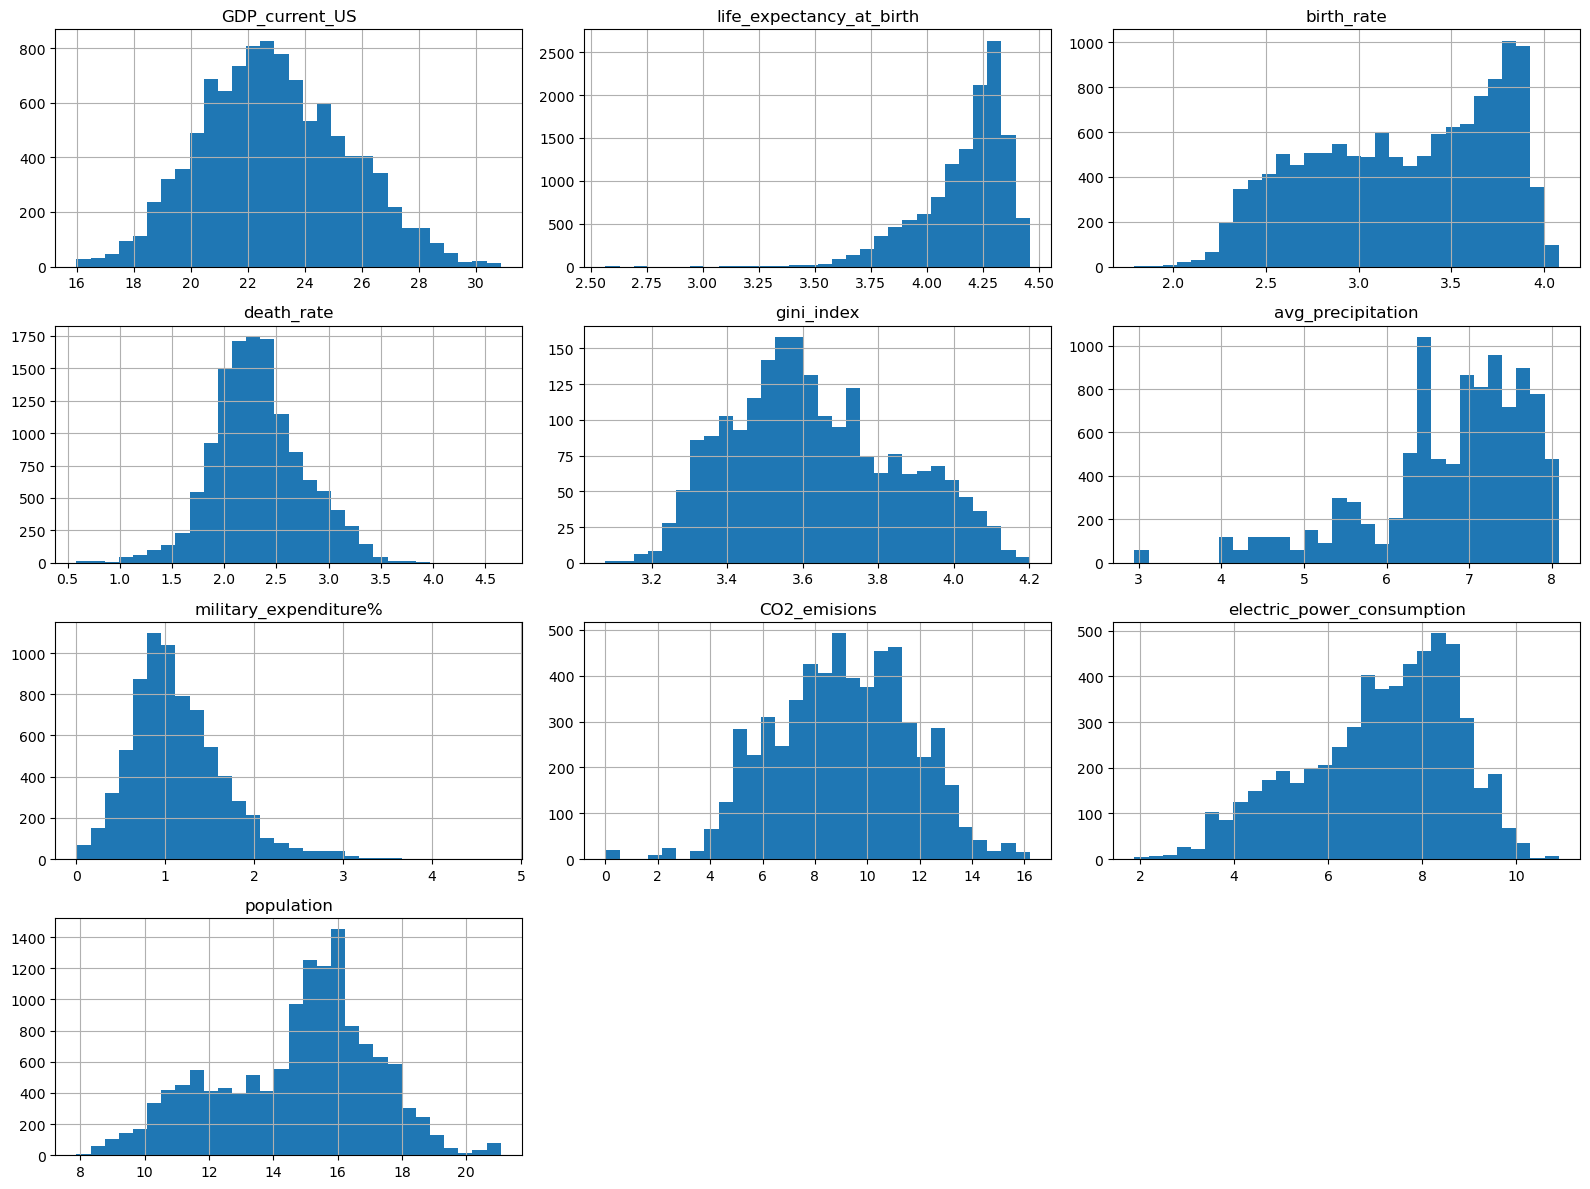

In [35]:
num_cols = [
    'GDP_current_US', 'life_expectancy_at_birth', 'birth_rate', 'death_rate',
    'gini_index', 'avg_precipitation', 'military_expenditure%',
    'CO2_emisions', 'electric_power_consumption', 'population'
]

# Create a log-transformed copy (add +1 to avoid log(0) issues)
df_log = df[num_cols].apply(lambda x: np.log(x + 1))

axes = df_log.hist(figsize=(16, 12), bins=30)

plt.tight_layout()
plt.show()


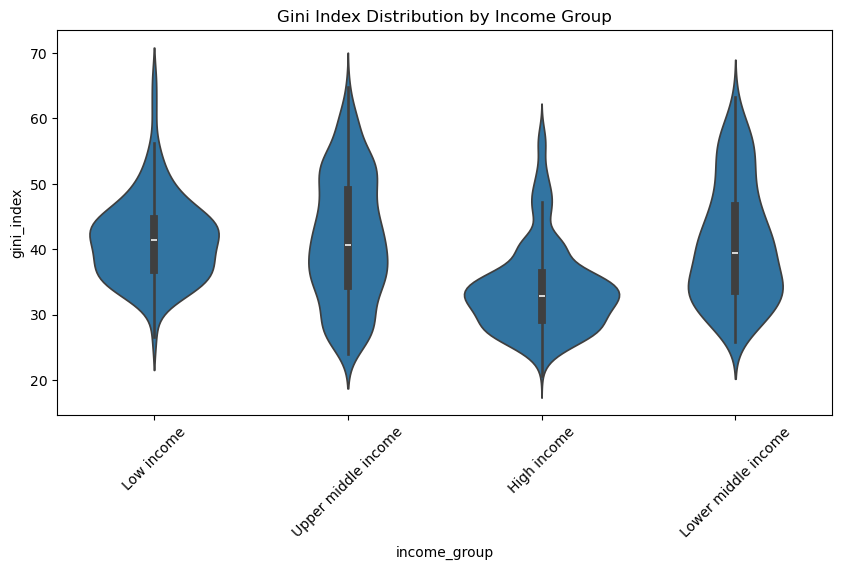

In [36]:
plt.figure(figsize=(10,5))
sns.violinplot(data=df, x='income_group', y='gini_index')
plt.xticks(rotation=45)
plt.title("Gini Index Distribution by Income Group")
plt.show()

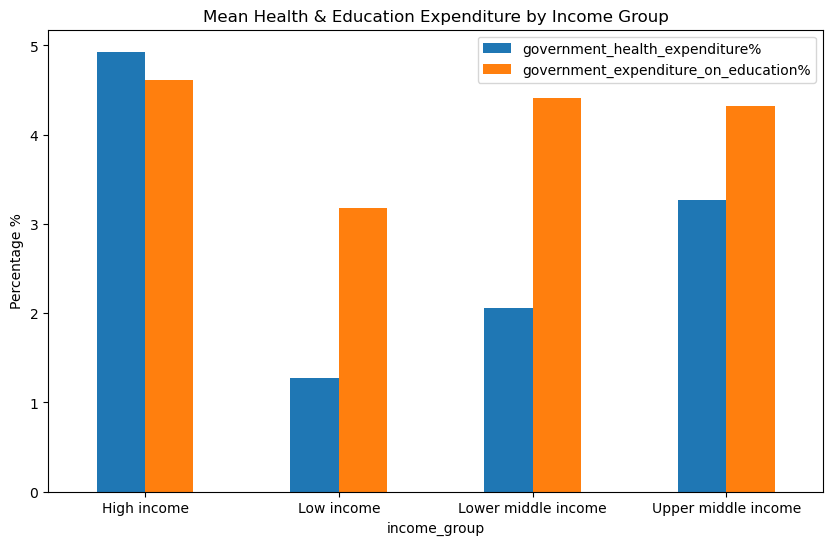

In [37]:
group_means = df.groupby('income_group')[
    ['government_health_expenditure%', 'government_expenditure_on_education%']].mean()

group_means.plot(kind='bar', figsize=(10,6))
plt.title("Mean Health & Education Expenditure by Income Group")
plt.ylabel("Percentage %")
plt.xticks(rotation=0)
plt.show()

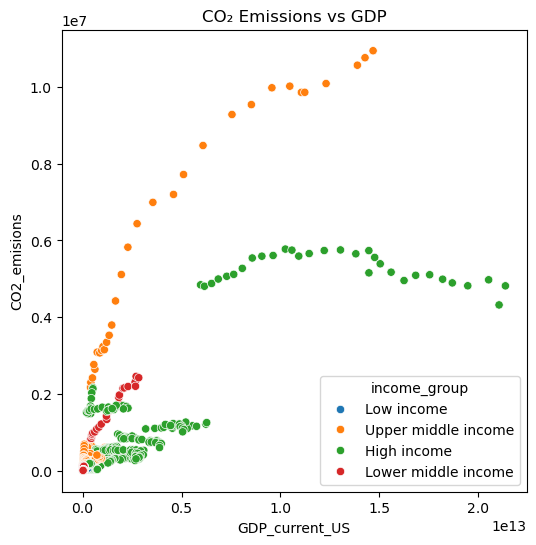

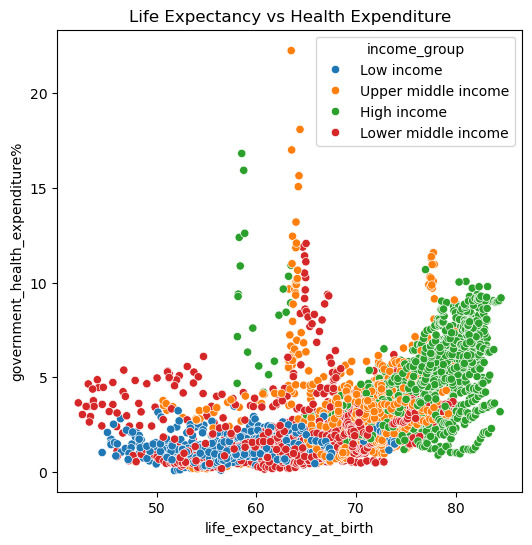

In [38]:

plt.figure(figsize=(6, 6))
sns.scatterplot(data=df, x='GDP_current_US', y='CO2_emisions', hue='income_group')
plt.title("CO₂ Emissions vs GDP")
plt.show()

plt.figure(figsize=(6, 6))
sns.scatterplot(data=df, x='life_expectancy_at_birth',
                y='government_health_expenditure%', hue='income_group')
plt.title("Life Expectancy vs Health Expenditure")
plt.show()

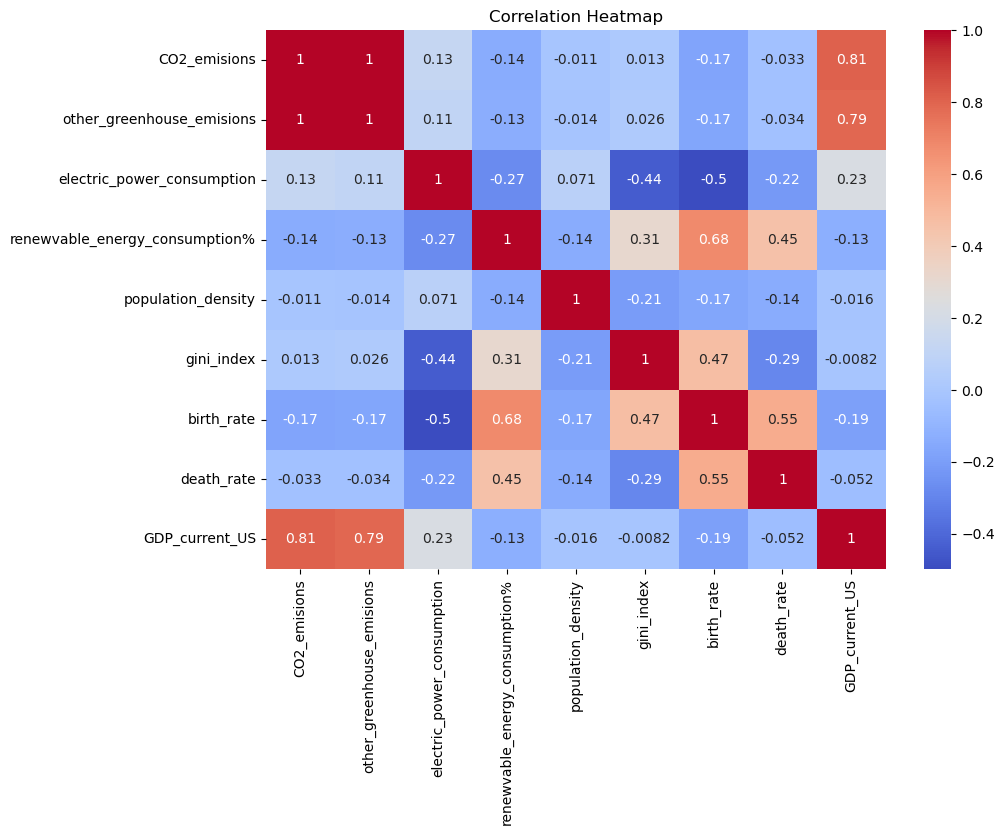

In [39]:
subset = df[
    ['CO2_emisions', 'other_greenhouse_emisions', 'electric_power_consumption',
     'renewvable_energy_consumption%', 'population_density', 'gini_index',
     'birth_rate', 'death_rate', 'GDP_current_US']
]

plt.figure(figsize=(10,7))
sns.heatmap(subset.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [40]:
def world_map(df, column, title=None):
    fig = px.choropleth(
        df,
        locations="country",                # uses country names
        locationmode="country names",
        color=column,
        hover_name="country",
        color_continuous_scale="RdYlGn",
        title=title if title else f"World Map of {column}",
    )
    fig.update_layout(
        geo=dict(showframe=False, showcoastlines=False),
        title_x=0.5
    )
    fig.show()


# GDP per country
world_map(df, "GDP_current_US", "GDP (Current US$)")

# Life Expectancy
world_map(df, "life_expectancy_at_birth", "Life Expectancy at Birth")

# CO₂ Emissions
world_map(df, "CO2_emisions", "CO₂ Emissions (kt)")

# nternet Usage %
world_map(df, "individuals_using_internet%", "Internet Usage (%)")


## Running Anova Test ( 1. Do different income groups differ in their GDP?)


In [41]:
anova_df = df[['income_group', 'GDP_current_US']].dropna()
# 3. Run One-Way ANOVA (Statsmodels)
# ----------------------------
model = ols('GDP_current_US ~ C(Q("income_group"))', data=anova_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("\nANOVA Results:")
print(anova_table)


ANOVA Results:
                            sum_sq       df          F        PR(>F)
C(Q("income_group"))  2.274151e+26      3.0  71.225738  1.375236e-45
Residual              1.099414e+28  10330.0        NaN           NaN


In [42]:
tukey = pairwise_tukeyhsd(endog=anova_df['GDP_current_US'],
                          groups=anova_df['income_group'],
                          alpha=0.05)

print("\nTukey Post-Hoc Test:")
print(tukey)


Tukey Post-Hoc Test:
                             Multiple Comparison of Means - Tukey HSD, FWER=0.05                              
       group1              group2            meandiff      p-adj        lower              upper        reject
--------------------------------------------------------------------------------------------------------------
        High income          Low income -361162764345.6502    0.0 -448481525702.4499 -273844002988.8505   True
        High income Lower middle income -327876061084.4037    0.0  -395080569623.338 -260671552545.4694   True
        High income Upper middle income  -213482824110.418    0.0 -280337050798.5844 -146628597422.2516   True
         Low income Lower middle income   33286703261.2465 0.7939  -59622546541.4587  126195953063.9518  False
         Low income Upper middle income  147679940235.2322 0.0002   55023745855.0694   240336134615.395   True
Lower middle income Upper middle income  114393236973.9856 0.0004   40386141097.3842  1884

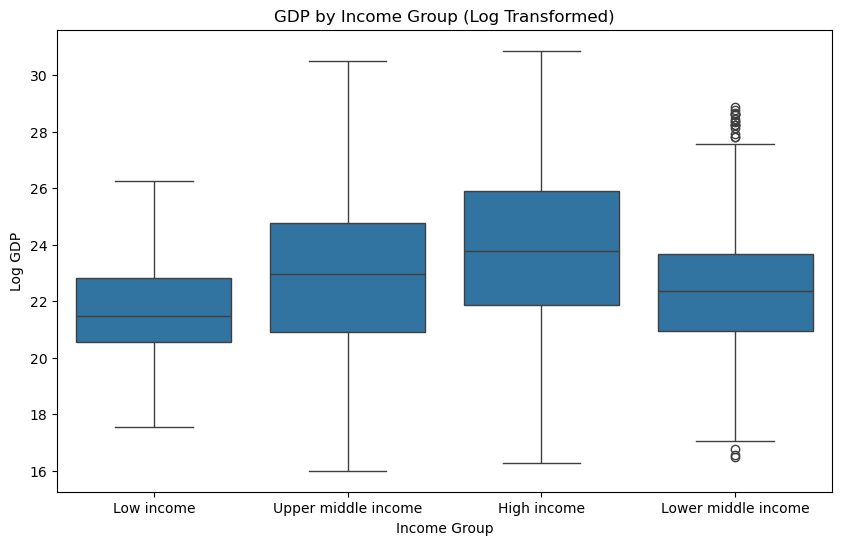

In [43]:
# Log-transform GDP to reduce outliers
anova_df['GDP_log'] = np.log1p(anova_df['GDP_current_US'])

plt.figure(figsize=(10, 6))
sns.boxplot(x='income_group', y='GDP_log', data=anova_df)
plt.title('GDP by Income Group (Log Transformed)')
plt.xlabel("Income Group")
plt.ylabel("Log GDP")
plt.show()

In [44]:
anova_df = df[['income_group', 'life_expectancy_at_birth']].dropna()
model = ols('life_expectancy_at_birth ~ C(Q("income_group"))', data=anova_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("\nANOVA Results:")
print(anova_table)


ANOVA Results:
                             sum_sq       df            F  PR(>F)
C(Q("income_group"))  826236.241093      3.0  4431.364706     0.0
Residual              789312.921077  12700.0          NaN     NaN


In [45]:

tukey = pairwise_tukeyhsd(endog=anova_df['life_expectancy_at_birth'],
                          groups=anova_df['income_group'],
                          alpha=0.05)

print("\nTukey Post-Hoc Test:")
print(tukey)


Tukey Post-Hoc Test:
              Multiple Comparison of Means - Tukey HSD, FWER=0.05              
       group1              group2       meandiff p-adj  lower    upper   reject
-------------------------------------------------------------------------------
        High income          Low income -23.0375   0.0 -23.6293 -22.4457   True
        High income Lower middle income -15.4887   0.0 -15.9598 -15.0176   True
        High income Upper middle income  -7.2479   0.0   -7.704  -6.7918   True
         Low income Lower middle income   7.5488   0.0   6.9155   8.1821   True
         Low income Upper middle income  15.7896   0.0  15.1673  16.4119   True
Lower middle income Upper middle income   8.2408   0.0   7.7319   8.7497   True
-------------------------------------------------------------------------------


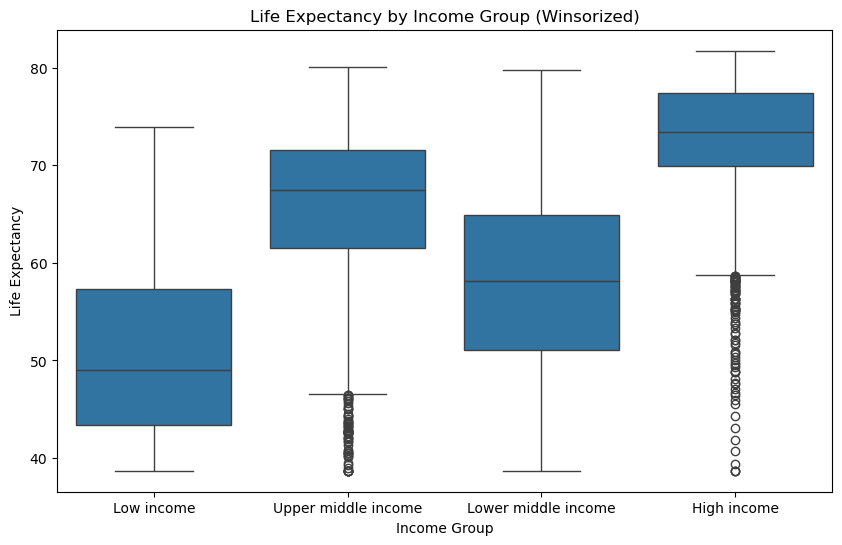

In [46]:
# Winsorize 2% on each side to reduce impact of outliers
lower = anova_df['life_expectancy_at_birth'].quantile(0.02)
upper = anova_df['life_expectancy_at_birth'].quantile(0.98)
anova_df['LE_winsor'] = np.clip(anova_df['life_expectancy_at_birth'], lower, upper)

plt.figure(figsize=(10, 6))
sns.boxplot(x='income_group', y='LE_winsor', data=anova_df)
plt.title('Life Expectancy by Income Group (Winsorized)')
plt.xlabel("Income Group")
plt.ylabel("Life Expectancy")
plt.show()

In [47]:
# List of selected vacation countries
vacation_countries = [
    'india', 'puerto rico us', 'greece', 'portugal', 'germany', 'brazil'
]

# Filter df for only these countries
anova_df = df[df['country'].str.lower().isin(vacation_countries)][
    ['country', 'avg_precipitation']
].dropna()

# Run One-Way ANOVA
model = ols('avg_precipitation ~ C(country)', data=anova_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("\nANOVA Results:")
print(anova_table)



ANOVA Results:
                 sum_sq     df              F  PR(>F)
C(country)  50250903.72    4.0  592500.883211     0.0
Residual        6254.85  295.0            NaN     NaN


In [48]:
tukey = pairwise_tukeyhsd(
    endog=anova_df['avg_precipitation'],
    groups=anova_df['country'],
    alpha=0.05
)

print("\nTukey Post-Hoc Test:")
print(tukey)


Tukey Post-Hoc Test:
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
 group1  group2  meandiff p-adj   lower      upper    reject
------------------------------------------------------------
 Brazil  Germany -1073.95   0.0 -1076.2575 -1071.6425   True
 Brazil   Greece -1121.95   0.0 -1124.2575 -1119.6425   True
 Brazil    India  -690.95   0.0  -693.2575  -688.6425   True
 Brazil Portugal  -919.95   0.0  -922.2575  -917.6425   True
Germany   Greece    -48.0   0.0   -50.3075   -45.6925   True
Germany    India    383.0   0.0   380.6925   385.3075   True
Germany Portugal    154.0   0.0   151.6925   156.3075   True
 Greece    India    431.0   0.0   428.6925   433.3075   True
 Greece Portugal    202.0   0.0   199.6925   204.3075   True
  India Portugal   -229.0   0.0  -231.3075  -226.6925   True
------------------------------------------------------------
